In [1]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import os
from time import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
import numpy as np
import keras.backend as K
path = ('/Users/carolinesklaver/Desktop/Capstone/NHANES/data/csv_data/')

import os
os.chdir(path)

SEED = 42

target = 'depressed'

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

## Get feature types

In [5]:
def var_type(df):
    # input dataframe
    # return continuous, non-continous, and multi-categorical features
 
    cols = df.columns
    cont = []
    non_cont = []
    cat_encode = []
    
    # get continuous variables
    for c in cols:
        if df[c].nunique() > 6:
            cont.append(c)
    
    # non cont is the difference
    non_cont = np.setdiff1d(cols, [cont])
    
    # multi-cat are those greater than 2
    for n in non_cont:
        if df[n].nunique() > 2:
            cat_encode.append(n)
    
    return cont, non_cont, cat_encode
    

## Encode multi-categorical features

In [6]:
def one_hot_encode(df, cat_encode):
    # takes in df and multi-cat features
    # returns df with features that are one-hot-encoded encoded and feature names
    
    cols = df.columns
    e_cols = list(set(cols).intersection(set(cat_encode)))
    df_encode = pd.get_dummies(df, columns=e_cols)
    
    features = np.setdiff1d(df_encode.columns, [target])

    return (df_encode, features)

## Split into training and testing & scale data

In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

def split_train_test(df, features, cont):
    # take in dataframe
    # output training features and binary target
    # output testing features and binary target
    
    
    # divide into training and testing
    df_raw_train, df_raw_test = train_test_split(df, test_size=0.33, random_state=SEED)
    # Reset the index
    df_raw_train, df_raw_test = df_raw_train.reset_index(drop=True), df_raw_test.reset_index(drop=True)

    # split training into train and validation
    df_train_split, df_raw_val = train_test_split(df_raw_train, test_size=0.2, random_state=SEED)
    # Reset the index
    df_train_split, df_raw_val = df_train_split.reset_index(drop=True), df_raw_val.reset_index(drop=True)

   
    
    # Make a copy of df_raw_train
    df_train = df_train_split.copy(deep=True)
    df_val = df_raw_val.copy(deep=True)
    # Make a copy of df_raw_test
    df_test = df_raw_test.copy(deep=True)


    # get feautre matrix
    x_train = df_train[features]
    x_val = df_val[features]
    x_test = df_test[features]
    
    y_train = df_train[target]
    y_val = df_val[target]
    y_test = df_test[target]
    
    
    # ---------------------- scale the continuous features --------------------
    x_train.astype('float32')
    x_val.astype('float32')
    x_test.astype('float32')

    cont_ss = []
    for var in cont:
        if var in x_train.columns:
            cont_ss.append(var)

    x_train[cont_ss] = ss.fit_transform(x_train[cont_ss])
    x_val[cont_ss] =ss.fit_transform(x_val[cont_ss])
    x_test[cont_ss] = ss.transform(x_test[cont_ss])
    # ---------------------------------------------------------------------------
    
    # get 2D output shape
    y_train_binary = keras.utils.to_categorical(y_train)
    y_val_binary = keras.utils.to_categorical(y_val)
    y_test_binary = keras.utils.to_categorical(y_test)
    
    # get input dimentions
    input_n = df_train.shape[1]-1

    print('Training data shape:', df_train.shape)
    print('Val data shape:', df_val.shape)
    print('Test data shape:', df_test.shape)
    print('Input shape:', input_n)
    
    
    return x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n



# Keras NN Model

In [17]:
def keras_model(input_n):

    # Define the model architecture
    model = keras.Sequential()

    model.add(layers.Dense(200, activation='relu' , input_dim=input_n))
    model.add(Dropout(0.2))
    model.add(layers.Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(60, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(60, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(2, activation='softmax'))

    # print(model.summary())

    return model

In [18]:
import keras
from keras import layers
from sklearn.model_selection import KFold
import numpy as np
import keras.backend as K
K.clear_session()
tf.config.experimental.set_visible_devices([], 'GPU')

# --------------------------------------- Plots ---------------------------------------
from matplotlib import pyplot as plt

def acc_loss_plots(hist):
    # list all data in history
    print(hist.history.keys())
    # summarize history for accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [27]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


# Define the K-fold Cross Validator
BATCH_SIZE=32
EPOCHS_1 = 25
num_folds=3

def nn_kfold(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    inputs = np.concatenate((x_train, x_val), axis=0)
    targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

        model = keras_model(input_n)
        
        if fold_no==1:
            print(model.summary())

        opt = keras.optimizers.rmsprop()

        model.compile(loss='binary_crossentropy',
                  optimizer=opt,metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if balanced_batches==True:
            training_generator, steps_per_epoch = balanced_batch_generator(inputs[train],targets[train],
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
            history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(inputs[test], targets[test]),
                                    epochs=EPOCHS_1, verbose=0)

        else:
            history = model.fit(inputs[train],targets[train], #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(inputs[test], targets[test]),
                        epochs=EPOCHS_1, verbose=0)



        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=1)
        
        # Generate a print
        print('------------------------------------------------------------------------')
        print(
        f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; '
        f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
        f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
        # plot Testing/Val accuracy and loss    
        if fold_no==num_folds:
            # plot the accuracy and loss for training/val by epoch
            acc_loss_plots(history)


        # Increase fold number
        fold_no = fold_no + 1
        
        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model



# CNN model

In [11]:
from __future__ import print_function    
from keras.models import Sequential
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

def cnn_model(input_n):
    model = Sequential()
    model.add(layers.Reshape((input_n,1), input_shape=(input_n,)))
    model.add(Conv1D(32, (2), input_shape=(input_n,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(32, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(64, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))


    # print(model.summary())
    
    return model

In [12]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


# Define the K-fold Cross Validator
BATCH_SIZE=32
EPOCHS_2 = 15
num_folds=3

def cnn_kfold(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    inputs = np.concatenate((x_train, x_val), axis=0)
    targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

        model = cnn_model(input_n)
        
        if fold_no==1:
            print(model.summary())

        opt = keras.optimizers.Adam()

        model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if balanced_batches==True:
            training_generator, steps_per_epoch = balanced_batch_generator(inputs[train],targets[train],
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
            history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(inputs[test], targets[test]),
                                    epochs=EPOCHS_2, verbose=0)

        else:
            history = model.fit(inputs[train],targets[train], #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(inputs[test], targets[test]),
                        epochs=EPOCHS_2, verbose=0)



        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=1)
        
        # Generate a print
        print('------------------------------------------------------------------------')
        print(
        f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; '
        f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
        f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
        # plot Testing/Val accuracy and loss    
        if fold_no==num_folds:
            # plot the accuracy and loss for training/val by epoch
            acc_loss_plots(history)


        # Increase fold number
        fold_no = fold_no + 1
        
        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model

In [15]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

BATCH_SIZE=32
EPOCHS_2 = 20

def cnn(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    # inputs = np.concatenate((x_train, x_val), axis=0)
    # targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    model = cnn_model(input_n)
    print(model.summary())

    opt = keras.optimizers.Adam()

    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

    # Generate a print
    print('------------------------------------------------------------------------')

    if balanced_batches==True:
        training_generator, steps_per_epoch = balanced_batch_generator(x_train, y_train_binary,
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
        history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(x_val, y_val_binary),
                                    epochs=EPOCHS_2, verbose=1)

    else:
        history = model.fit(x_train, y_train_binary, #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(x_val, y_val_binary),
                        epochs=EPOCHS_2, verbose=1)



    # Generate generalization metrics
    scores = model.evaluate(x_val, y_val_binary, verbose=1)
        
    # Generate a print
    print('------------------------------------------------------------------------')
    print(
    f'Score for val cnn: {model.metrics_names[0]} of {scores[0]}; '
    f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
    f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
    # plot Testing/Val accuracy and loss    
    acc_loss_plots(history)

        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model

## Original Data from NHANES

In [34]:
df_raw_mlp =  pd.read_csv('df_progressive_mlp_2.csv')  # 53 columns
df_raw_mlp.head()

,SEQN,year,depressed,race_ethnicity,edu_level,#_ppl_household,age,gender,marital_status,annual_HI,...,systolic_BP,diastolic_BP,BMI,waist_C,#meals_fast_food,min_sedetary,doc_HPV,bone_mineral_density,difficult_hearing,doc_COPD
0,31131.0,2005-2006,0.0,4.0,4.0,4.0,44.0,2.0,1.0,11.0,...,144.0,74.0,30.90,96.0,1.794356,25.937662,0.0,0.841958,0.0,0.0
1,31132.0,2005-2006,0.0,3.0,5.0,2.0,70.0,1.0,1.0,11.0,...,138.0,60.0,24.74,96.5,0.953694,25.937662,0.0,0.841958,0.0,0.0
2,31134.0,2005-2006,0.0,3.0,3.0,2.0,73.0,1.0,1.0,11.0,...,130.0,68.0,30.63,117.1,0.953694,25.937662,0.0,0.841958,0.0,0.0
3,31139.0,2005-2006,0.0,2.0,4.0,3.0,18.0,2.0,5.0,11.0,...,110.0,64.0,29.45,84.0,2.181368,25.937662,0.0,0.841958,0.0,0.0
4,31143.0,2005-2006,0.0,3.0,4.0,3.0,19.0,1.0,5.0,11.0,...,108.0,62.0,22.57,84.2,3.324394,25.937662,0.0,0.841958,0.0,0.0


Training data shape: (16807, 80)
Val data shape: (4202, 80)
Test data shape: (10348, 80)
Input shape: 79
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_167 (Dense)            (None, 200)               16000     
_________________________________________________________________
dropout_147 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_168 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_148 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_169 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_149 (Dropout)        (None, 100)               0         
______________

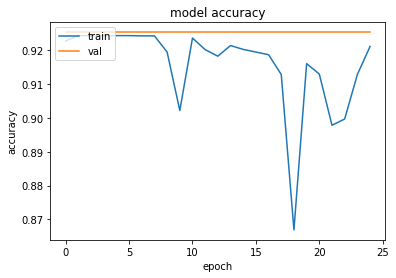

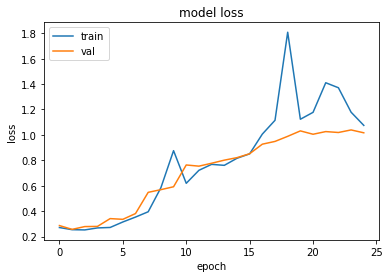

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
nn_kfold(df_raw_mlp)

Training data shape: (16807, 80)
Val data shape: (4202, 80)
Test data shape: (10348, 80)
Input shape: 79
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 79, 1)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 78, 32)            96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 78, 32)            128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 77, 32)            2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 77, 32)            128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 76, 64)            4160      
______________

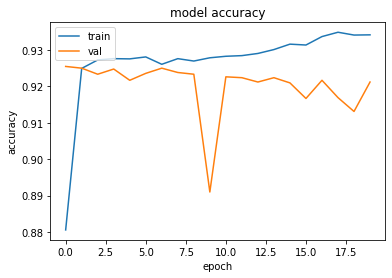

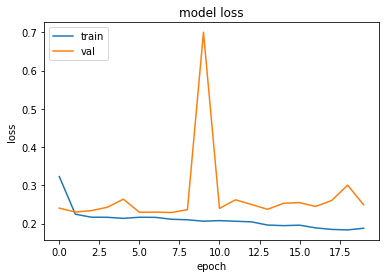

[[9443  138]
 [ 669   98]]
F1 score: 0.1954137587238285
Precision: 0.4152542372881356
Recall: 0.12777053455019557
Accuracy: 0.9220139157325087
ROC AUC: 0.5566835138046876


In [36]:
cnn(df_raw_mlp)

Training data shape: (16807, 80)
Val data shape: (4202, 80)
Test data shape: (10348, 80)
Input shape: 79
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_196 (Dense)            (None, 200)               16000     
_________________________________________________________________
dropout_172 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_197 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_173 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_198 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_174 (Dropout)        (None, 100)               0         
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 196us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.8173922343916609;  accuracy of 0.7536770105361938; precision of 0.7536770105361938; recall of 0.7536770105361938; AUC of 0.8203524351119995;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 179us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.152504034507416;  accuracy of 0.6809938549995422; precision of 0.6809938549995422; recall of 0.6809938549995422; AUC of 0.7461614012718201;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 202us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.1124364343963487;  accuracy of 0.7029844522476196; precision of 0.7029844522476196; recall of 0.7029844522476196; AUC of 0.754606306552887;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


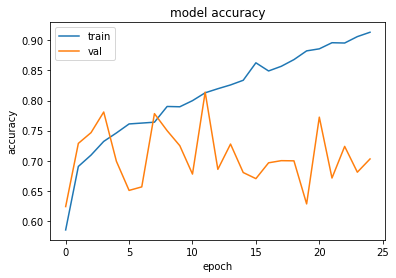

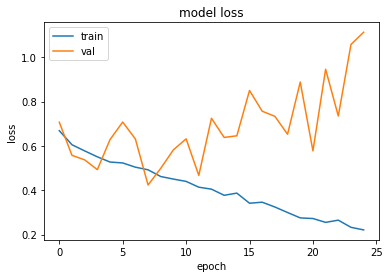

[[6562 3019]
 [ 270  497]]
F1 score: 0.23208031753443847
Precision: 0.141353811149033
Recall: 0.6479791395045632
Accuracy: 0.6821608040201005
ROC AUC: 0.6664381659322212


In [37]:
nn_kfold(df_raw_mlp, balanced_batches=True)

In [ ]:
cnn(df_raw_mlp, balanced_batches=True)

Training data shape: (16807, 80)
Val data shape: (4202, 80)
Test data shape: (10348, 80)
Input shape: 79
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 79, 1)             0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 78, 32)            96        
_________________________________________________________________
batch_normalization_36 (Batc (None, 78, 32)            128       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 77, 32)            2080      
_________________________________________________________________
batch_normalization_37 (Batc (None, 77, 32)            128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 76, 64)            4160      
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


## Data with more features from NHANES

In [ ]:
# read in normal MLP imputed more features data
df_raw_mlp_OG =  pd.read_csv('df_progressive_mlp_ext_ext.csv')  # 112 columns
df_raw_mlp_OG.head()


Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               33400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

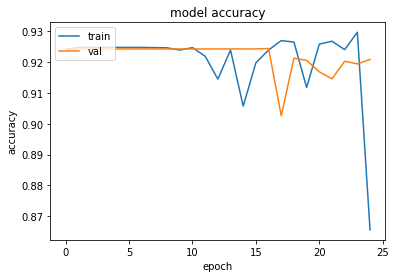

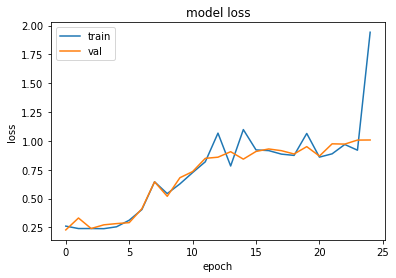

[[9433  148]
 [ 672   95]]
F1 score: 0.1881188118811881
Precision: 0.39094650205761317
Recall: 0.12385919165580182
Accuracy: 0.9207576343254735
ROC AUC: 0.5542059761639828


In [20]:
nn_kfold(df_raw_mlp_OG)

Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 166, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 165, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 165, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 164, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 164, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 163, 64)           4160      
___________

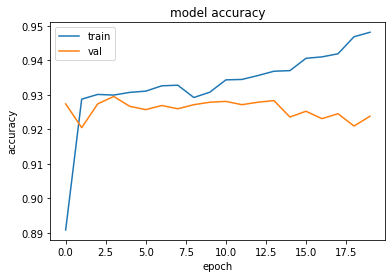

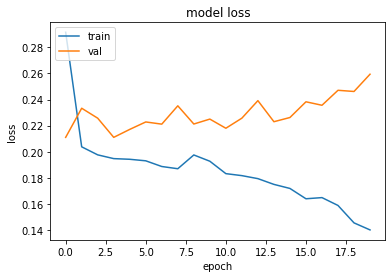

[[9366  215]
 [ 589  178]]
F1 score: 0.306896551724138
Precision: 0.4529262086513995
Recall: 0.2320730117340287
Accuracy: 0.9223038268264399
ROC AUC: 0.6048163827065927


In [16]:
cnn(df_raw_mlp_OG)

Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 200)               33400     
_________________________________________________________________
dropout_58 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_59 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_60 (Dropout)         (None, 100)               0         
___________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 178us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.819214887828737;  accuracy of 0.7035556435585022; precision of 0.7035556435585022; recall of 0.7035556435585022; AUC of 0.7192448377609253;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 188us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.8399652710952334;  accuracy of 0.7332571744918823; precision of 0.7332571744918823; recall of 0.7332571744918823; AUC of 0.7918371558189392;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 222us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.7237184842143862;  accuracy of 0.7455376386642456; precision of 0.7455376386642456; recall of 0.7455376386642456; AUC of 0.8080606460571289;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


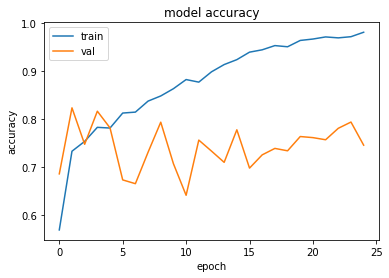

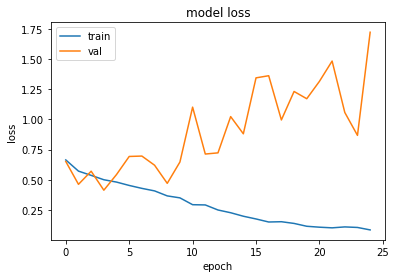

[[7060 2521]
 [ 246  521]]
F1 score: 0.2735626148595432
Precision: 0.1712689020381328
Recall: 0.6792698826597132
Accuracy: 0.7326053343641283
ROC AUC: 0.7080724739464936


In [28]:
nn_kfold(df_raw_mlp_OG, balanced_batches=True)

In [ ]:
cnn(df_raw_mlp_OG, balanced_batches=True)

## Subset of NHANES features 1/3

In [44]:
subset1 = ['depressed','tried_lose_weight', 'triglyceride', 'tot_cholesterol', 'glycohemoglobin', 
           'herpes_2', 'HIV', 'rbc_folate', 'serum_folate', 'fasting_glucose', 'lab_VitD', 
           'systolic_BP', 'diastolic_BP', 'pulse', 'BMI', 'waist_C', 'VitD', '#meals_fast_food', 
           'monthly_income', 'savings_5000', 'min_sedetary', 'doc_HPV', 'oral_rec', 
           'difficult_remembering', 'prob_smell', 'prob_tatse', 'persistent_cold', 
           'nasal_congestion', 'serum_selenium', 'serum_zinc', 'serum_creatinine', 
           'lab_VitB12', 'bone_mineral_density', 'difficult_hearing', 'difficult_seeing', 
           'difficult_walking', 'difficult_errands']

df_mlp_sub1 = df_raw_mlp_OG[subset1]


Training data shape: (16807, 40)
Val data shape: (4202, 40)
Test data shape: (10348, 40)
Input shape: 39
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_279 (Dense)            (None, 200)               8000      
_________________________________________________________________
dropout_245 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_280 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_246 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_281 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_247 (Dropout)        (None, 100)               0         
______________

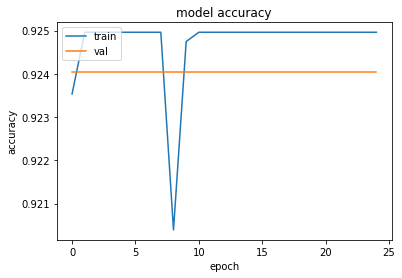

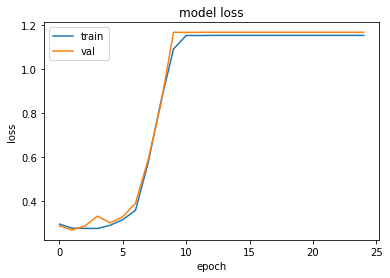

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
nn_kfold(df_mlp_sub1)

Training data shape: (16807, 40)
Val data shape: (4202, 40)
Test data shape: (10348, 40)
Input shape: 39
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 39, 1)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 38, 32)            96        
_________________________________________________________________
batch_normalization_21 (Batc (None, 38, 32)            128       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 37, 32)            2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 37, 32)            128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 36, 64)            4160      
______________

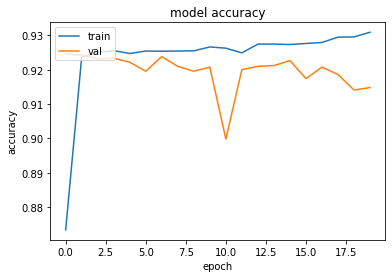

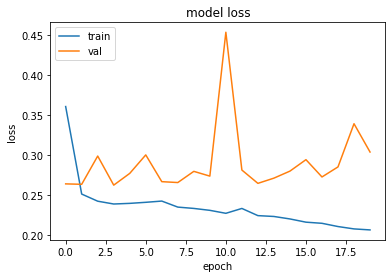

[[9453  128]
 [ 710   57]]
F1 score: 0.11974789915966386
Precision: 0.3081081081081081
Recall: 0.07431551499348109
Accuracy: 0.9190181677618864
ROC AUC: 0.5304778702198384


In [46]:
cnn(df_mlp_sub1)

Training data shape: (16807, 40)
Val data shape: (4202, 40)
Test data shape: (10348, 40)
Input shape: 39
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_308 (Dense)            (None, 200)               8000      
_________________________________________________________________
dropout_270 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_309 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_271 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_310 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_272 (Dropout)        (None, 100)               0         
______________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 264us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.8001797895984413;  accuracy of 0.617592453956604; precision of 0.617592453956604; recall of 0.617592453956604; AUC of 0.6880192756652832;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 252us/step
------------------------------------------------------------------------
Score for fold 2: loss of 0.7134835742702318;  accuracy of 0.600456953048706; precision of 0.600456953048706; recall of 0.600456953048706; AUC of 0.7085743546485901;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 245us/step
------------------------------------------------------------------------
Score for fold 3: loss of 0.7186488023863747;  accuracy of 0.5907468199729919; precision of 0.5907468199729919; recall of 0.5907468199729919; AUC of 0.6570233702659607;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


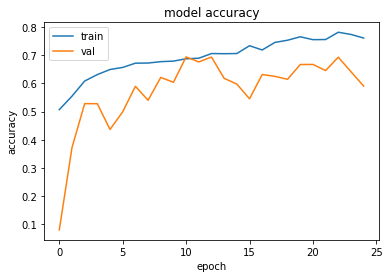

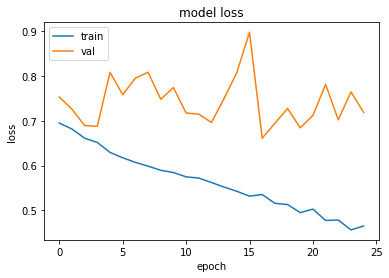

[[5642 3939]
 [ 265  502]]
F1 score: 0.19278033794162827
Precision: 0.11303760414321098
Recall: 0.6544980443285529
Accuracy: 0.5937379203710862
ROC AUC: 0.6216859285414813


In [47]:
nn_kfold(df_mlp_sub1, balanced_batches=True)

In [ ]:
cnn(df_mlp_sub1, balanced_batches=True)

## Subset intuitively chosen 1/2

In [48]:
subset2 = ['depressed', 'race_ethnicity', 'edu_level', 'age', 'gender', 'annual_HI',
              'marital_status', 'special_diet', 'protein', 'carb','sugar', 'fiber', 'fat', 
               'diet_chol', 'VitB6', 'folate', 'VitB12', 'doc_diabetes','how_healthy_diet', 
               'used_CMH', 'gen_health_cond','healthcare_past_yr', 'run_out_food', 'afford_balanced_meals',
              'food_security_cat', 'food_stamps', 'doc_asthma','doc_overweight', 'doc_arthritis', 
               'doc_CHD','doc_heart_attack', 'doc_stroke', 'doc_chronic_bronchitis',
               'doc_liver_condition', 'doc_thyroid_problem', 'doc_cancer','anemia', 'doc_kidney',
               'work_type', 'embarassed_mouth', 'lab_B12', 'vigorous_activity','moderate_activity', 
               'hours_TV', 'hours_computer','manage_$_difficult', 'doc_sleeping_disorder','hrs_sleep',
              'smoked_5days', 'sexual_orientation','alcoholic', 'consider_weight','triglyceride', 'tot_cholesterol',
              'rbc_folate','fasting_glucose', 'lab_VitD','BMI','min_sedetary','difficult_remembering',
              'persistent_cold','lab_VitB12','difficult_errands', 'doc_COPD']

df_mlp_sub2 = df_raw_mlp_OG[subset2]

Training data shape: (16807, 105)
Val data shape: (4202, 105)
Test data shape: (10348, 105)
Input shape: 104
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_335 (Dense)            (None, 200)               21000     
_________________________________________________________________
dropout_294 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_336 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_295 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_337 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_296 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 249us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.116379875226411;  accuracy of 0.7501071095466614; precision of 0.7501071095466614; recall of 0.7501071095466614; AUC of 0.8254075646400452;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 273us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.0326356680992754;  accuracy of 0.7488219141960144; precision of 0.7488219141960144; recall of 0.7488219141960144; AUC of 0.8058266043663025;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 257us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.8850738698544545;  accuracy of 0.6825646162033081; precision of 0.6825646162033081; recall of 0.6825646162033081; AUC of 0.7249933481216431;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


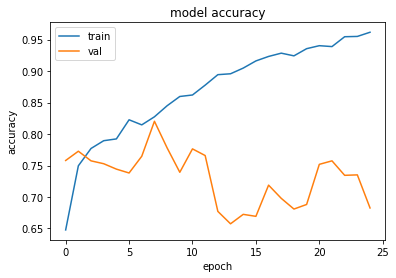

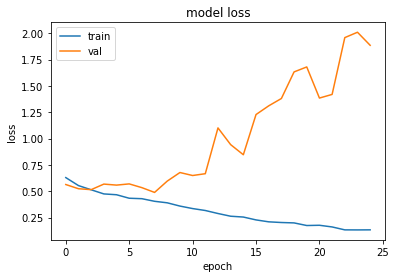

[[6423 3158]
 [ 190  577]]
F1 score: 0.2563305197689915
Precision: 0.15448460508701473
Recall: 0.7522816166883963
Accuracy: 0.6764592191727871
ROC AUC: 0.7113354644343767


In [49]:
nn_kfold(df_mlp_sub2, balanced_batches=True)

Training data shape: (16807, 105)
Val data shape: (4202, 105)
Test data shape: (10348, 105)
Input shape: 104
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 104, 1)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 103, 32)           96        
_________________________________________________________________
batch_normalization_26 (Batc (None, 103, 32)           128       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 102, 32)           2080      
_________________________________________________________________
batch_normalization_27 (Batc (None, 102, 32)           128       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 101, 64)           4160      
__________

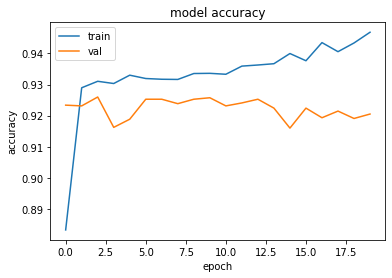

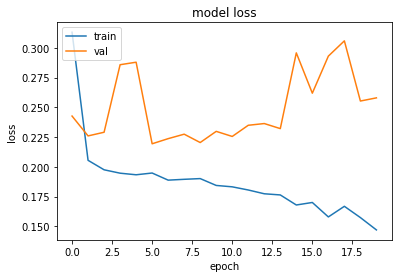

[[9348  233]
 [ 585  182]]
F1 score: 0.3079526226734349
Precision: 0.43855421686746987
Recall: 0.23728813559322035
Accuracy: 0.9209509083880943
ROC AUC: 0.6064845854878741


In [50]:
cnn(df_mlp_sub2)

Training data shape: (16807, 105)
Val data shape: (4202, 105)
Test data shape: (10348, 105)
Input shape: 104
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_364 (Dense)            (None, 200)               21000     
_________________________________________________________________
dropout_319 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_365 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_320 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_366 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_321 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 260us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.4313328904150964;  accuracy of 0.7616735696792603; precision of 0.7616735696792603; recall of 0.7616735696792603; AUC of 0.8077372312545776;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 263us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.0712197271565207;  accuracy of 0.762101948261261; precision of 0.762101948261261; recall of 0.762101948261261; AUC of 0.8097773790359497;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 274us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.3411064476825911;  accuracy of 0.6765671968460083; precision of 0.6765671968460083; recall of 0.6765671968460083; AUC of 0.7438409924507141;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


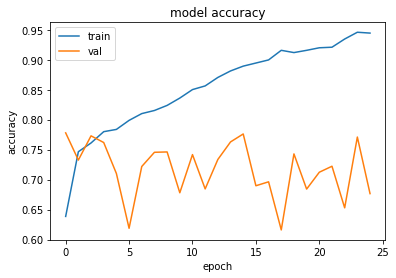

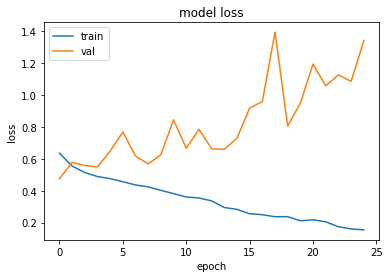

[[6404 3177]
 [ 196  571]]
F1 score: 0.2529346622369878
Precision: 0.1523479188900747
Recall: 0.7444589308996089
Accuracy: 0.6740432933900271
ROC AUC: 0.7064325757723177


In [51]:
nn_kfold(df_mlp_sub2, balanced_batches=True)

Training data shape: (16807, 105)
Val data shape: (4202, 105)
Test data shape: (10348, 105)
Input shape: 104
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 104, 1)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 103, 32)           96        
_________________________________________________________________
batch_normalization_31 (Batc (None, 103, 32)           128       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 102, 32)           2080      
_________________________________________________________________
batch_normalization_32 (Batc (None, 102, 32)           128       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 101, 64)           4160      
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


4202/4202 [==============================] - 10s 2ms/step
------------------------------------------------------------------------
Score for val cnn: loss of 0.7957819328882307;  accuracy of 0.7289385795593262; precision of 0.7289385795593262; recall of 0.7289385795593262; AUC of 0.8003073334693909;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


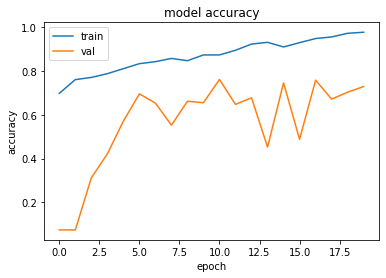

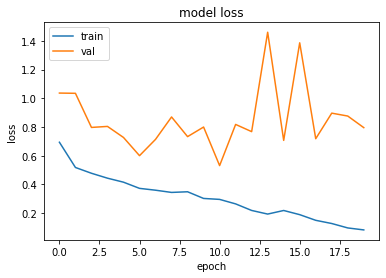

[[7147 2434]
 [ 264  503]]
F1 score: 0.27159827213822896
Precision: 0.17126319373510385
Recall: 0.6558018252933507
Accuracy: 0.7392732895245459
ROC AUC: 0.700878681146832


In [52]:
cnn(df_mlp_sub2, balanced_batches=True)

## Created new features (categorical)

In [38]:
df_raw_mlp_ext =  pd.read_csv('df_feature_mlp_ext.csv')

df_ext_square = df_raw_mlp_ext[df_raw_mlp_ext.columns.drop(list(df_raw_mlp_ext.filter(regex='_2')))]

Training data shape: (16807, 187)
Val data shape: (4202, 187)
Test data shape: (10348, 187)
Input shape: 186
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_223 (Dense)            (None, 200)               37400     
_________________________________________________________________
dropout_196 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_224 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_197 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_225 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_198 (Dropout)        (None, 100)               0         
__________

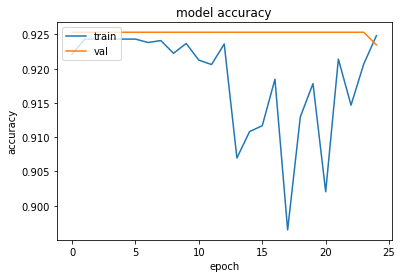

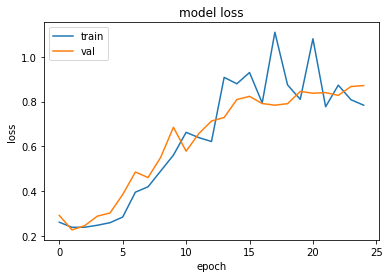

[[9466  115]
 [ 662  105]]
F1 score: 0.21276595744680854
Precision: 0.4772727272727273
Recall: 0.13689700130378096
Accuracy: 0.9249130266718206
ROC AUC: 0.5624470394265486


In [39]:
nn_kfold(df_ext_square)

Training data shape: (16807, 187)
Val data shape: (4202, 187)
Test data shape: (10348, 187)
Input shape: 186
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 186, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 185, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 185, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 184, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 184, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 183, 64)           4160      
__________

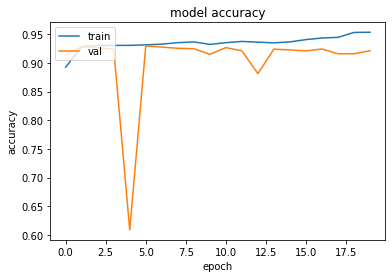

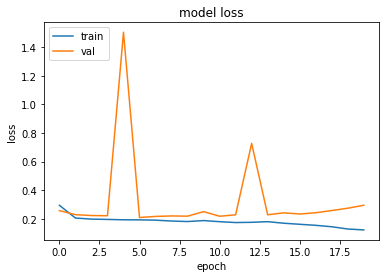

[[9377  204]
 [ 608  159]]
F1 score: 0.2814159292035398
Precision: 0.4380165289256198
Recall: 0.20730117340286833
Accuracy: 0.9215307305759567
ROC AUC: 0.5930045163538713


In [40]:
cnn(df_ext_square)

Training data shape: (16807, 187)
Val data shape: (4202, 187)
Test data shape: (10348, 187)
Input shape: 186
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_252 (Dense)            (None, 200)               37400     
_________________________________________________________________
dropout_221 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_253 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_222 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_254 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_223 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 270us/step
------------------------------------------------------------------------
Score for fold 1: loss of 2.242154469272843;  accuracy of 0.723975419998169; precision of 0.723975419998169; recall of 0.723975419998169; AUC of 0.7389461994171143;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 261us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.641159088428099;  accuracy of 0.7423961162567139; precision of 0.7423961162567139; recall of 0.7423961162567139; AUC of 0.7795184254646301;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 2s 232us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.774083107109838;  accuracy of 0.7268313765525818; precision of 0.7268313765525818; recall of 0.7268313765525818; AUC of 0.780707061290741;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


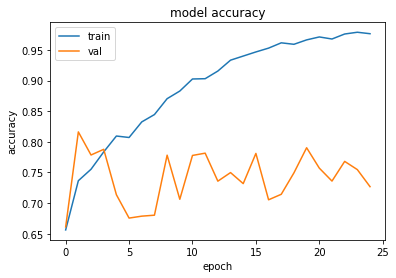

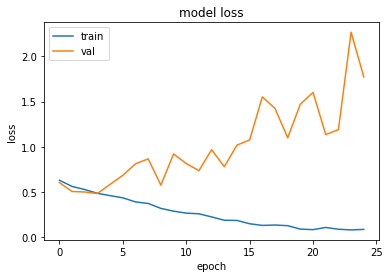

[[6849 2732]
 [ 215  552]]
F1 score: 0.2725253023944705
Precision: 0.16808769792935443
Recall: 0.7196870925684485
Accuracy: 0.7152106687282567
ROC AUC: 0.7172697022178428


In [41]:
nn_kfold(df_ext_square, balanced_batches=True)

In [ ]:
cnn(df_ext_square, balanced_batches=True)

## + squared continous columns

In [30]:
df_raw_mlp_ext.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_2,serum_zinc_2,serum_creatinine_2,lab_VitB12_2,bone_mineral_density_2,#_chronic_condition_2,hours_screen_2,combined_BP_2,people_per_rooms_2,diet_tot_VitB_2
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.000000,1.0,...,12581.180396,4991.680256,9.059151,198305.571052,0.445877,1.0,4.0,47524.0,0.250000,90249.172225
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.000000,1.0,...,17001.069514,6138.685741,9.059151,381841.413723,0.445877,4.0,4.0,39204.0,0.062500,663283.194084
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,7.566928,1.0,...,15055.057823,5831.331824,9.059151,132595.480327,0.445877,1.0,1.0,39204.0,0.081633,83303.236129
3,0.0,0.0,0.0,2.0,4.0,3.0,18.0,0.0,11.000000,5.0,...,15539.407404,6407.888282,9.059151,407710.932855,0.445877,4.0,64.0,30276.0,0.140625,95127.831184
4,0.0,0.0,0.0,3.0,4.0,3.0,19.0,1.0,11.000000,5.0,...,13672.703062,5408.978846,9.059151,261492.485488,0.445877,0.0,36.0,28900.0,0.183673,288015.762241


Training data shape: (16807, 241)
Val data shape: (4202, 241)
Test data shape: (10348, 241)
Input shape: 240
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 200)               48200     
_________________________________________________________________
dropout_98 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_112 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_99 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_113 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_100 (Dropout)        (None, 100)               0         
__________

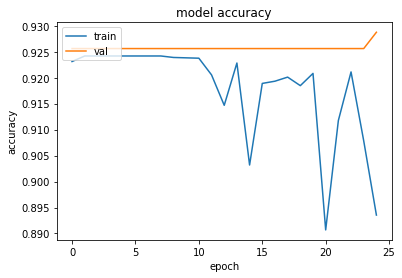

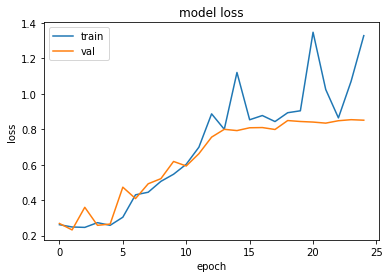

[[9521   60]
 [ 695   72]]
F1 score: 0.16017797552836485
Precision: 0.5454545454545454
Recall: 0.0938722294654498
Accuracy: 0.9270390413606494
ROC AUC: 0.5438049175716769


In [31]:
nn_kfold(df_raw_mlp_ext)

Training data shape: (16807, 241)
Val data shape: (4202, 241)
Test data shape: (10348, 241)
Input shape: 240
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 240, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 239, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 239, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 238, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 238, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 237, 64)           4160      
__________

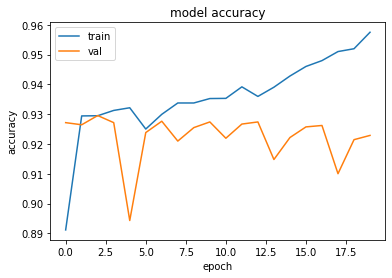

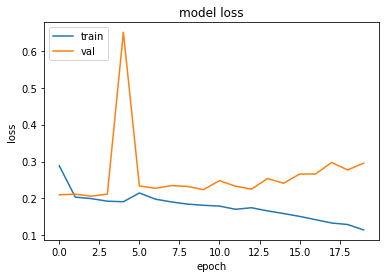

[[9335  246]
 [ 608  159]]
F1 score: 0.2713310580204778
Precision: 0.3925925925925926
Recall: 0.20730117340286833
Accuracy: 0.91747197526092
ROC AUC: 0.5908126783411377


In [32]:
cnn(df_raw_mlp_ext)

Training data shape: (16807, 241)
Val data shape: (4202, 241)
Test data shape: (10348, 241)
Input shape: 240
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_140 (Dense)            (None, 200)               48200     
_________________________________________________________________
dropout_123 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_141 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_124 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_142 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_125 (Dropout)        (None, 100)               0         
__________

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 200us/step
------------------------------------------------------------------------
Score for fold 1: loss of 1.8786409382954268;  accuracy of 0.7428244948387146; precision of 0.7428244948387146; recall of 0.7428244948387146; AUC of 0.7876890897750854;
------------------------------------------------------------------------
Training for fold 2 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 1s 206us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.9551996863536898;  accuracy of 0.6672854423522949; precision of 0.6672854423522949; recall of 0.6672854423522949; AUC of 0.6895846128463745;
------------------------------------------------------------------------
Training for fold 3 ...


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


7003/7003 [==============================] - 4s 616us/step
------------------------------------------------------------------------
Score for fold 3: loss of 1.9067986491882987;  accuracy of 0.7064115405082703; precision of 0.7064115405082703; recall of 0.7064115405082703; AUC of 0.7336987853050232;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


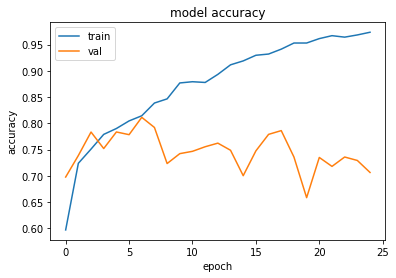

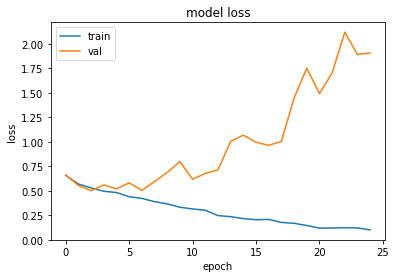

[[6603 2978]
 [ 206  561]]
F1 score: 0.26056665118439387
Precision: 0.15851935575021192
Recall: 0.7314211212516297
Accuracy: 0.6923076923076923
ROC AUC: 0.710298808199137


In [33]:
nn_kfold(df_raw_mlp_ext, balanced_batches=True)

In [ ]:
cnn(df_raw_mlp_ext, balanced_batches=True)